<a href="https://colab.research.google.com/github/ben45123/AWS-Lambda-Research/blob/main/ComputerVisionFinalProject/FaceShapeFineTuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Cell 1: Import & mount Drive + set OUTPUT_DIR
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import shutil
import kagglehub

print("TensorFlow version:", tf.__version__)

# Point this at a folder in your Drive
OUTPUT_DIR = '/content/drive/MyDrive/face_shape_models/'
os.makedirs(OUTPUT_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.18.0


In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
# Cell 2: Download & Organize Dataset Structure

# 1) Download archive
path = kagglehub.dataset_download("niten19/face-shape-dataset")
print("Path to dataset files:", path)

# 2) Locate the real root (inside “FaceShape Dataset”)
dataset_root = os.path.join(path, "FaceShape Dataset")
train_src    = os.path.join(dataset_root, "training_set")

# 3) Define the split function
from sklearn.model_selection import train_test_split

def organize_dataset(src_folder, class_name):
    files = [f for f in os.listdir(src_folder)
             if f.lower().endswith(('.jpg','.png','.jpeg'))]
    train_f, temp   = train_test_split(files, test_size=0.3, random_state=42)
    val_f, test_f   = train_test_split(temp,  test_size=0.5, random_state=42)
    for split, flist in [("train", train_f),
                         ("validation", val_f),
                         ("test", flist := test_f)]:
        dst_dir = os.path.join(BASE_DIR, split, class_name)
        for fname in flist:
            shutil.copy(os.path.join(src_folder, fname),
                        os.path.join(dst_dir, fname))
    print(f"{class_name}: {len(train_f)} train, {len(val_f)} val, {len(test_f)} test")

# 4) Create  split directories
for split in ["train","validation","test"]:
    for cls in CLASS_NAMES:
        os.makedirs(os.path.join(BASE_DIR, split, cls), exist_ok=True)

# 5) Run the split for each class
for cls in CLASS_NAMES:
    organize_dataset(os.path.join(train_src, cls), cls)


Path to dataset files: /kaggle/input/face-shape-dataset
Heart: 560 train, 120 val, 120 test
Oblong: 560 train, 120 val, 120 test
Oval: 560 train, 120 val, 120 test
Round: 560 train, 120 val, 120 test
Square: 560 train, 120 val, 120 test


In [11]:
# Cell 3: Configuration parameters
IMG_SIZE    = 224
BATCH_SIZE  = 32
EPOCHS      = 15
NUM_CLASSES = len(CLASS_NAMES)

TRAIN_DIR = f"{BASE_DIR}/train"
VAL_DIR   = f"{BASE_DIR}/validation"
TEST_DIR  = f"{BASE_DIR}/test"

In [16]:
# Cell 4: Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

print("Generators ready:",
      len(train_generator), "train batches,",
      len(validation_generator), "val batches.")


Found 2800 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Generators ready: 88 train batches, 19 val batches.


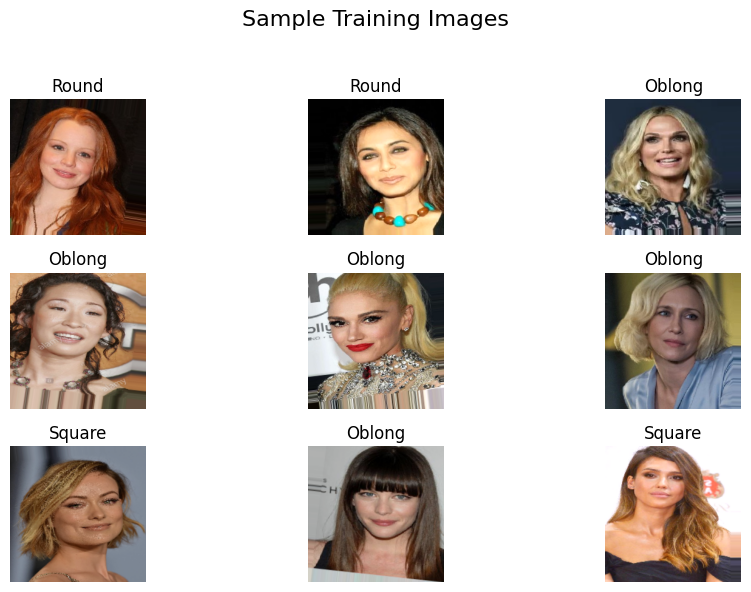

In [17]:
# Cell 5: Visualize Sample Images
def display_sample(generator, title):
    x, y = next(generator)
    plt.figure(figsize=(10,6))
    plt.suptitle(title, fontsize=16)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x[i])
        label = CLASS_NAMES[np.argmax(y[i])]
        plt.title(label)
        plt.axis('off')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

display_sample(train_generator, "Sample Training Images")

In [18]:
from tensorflow.keras.layers import BatchNormalization

# Cell 6
def build_model(num_classes=NUM_CLASSES):
    base = MobileNetV2(weights='imagenet', include_top=False,
                       input_shape=(IMG_SIZE,IMG_SIZE,3))
    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    preds = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=preds)
    model.base_model = base
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()


In [22]:
# Cell 7: Callbacks for Training
checkpoint_path = os.path.join(OUTPUT_DIR, "face_shape_best.h5")

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

In [ ]:
# # ----- Old Cell 8 (head-only training) -----
# # history = model.fit(
# #     train_generator,
# #     epochs=EPOCHS,
# #     validation_data=validation_generator,
# #     callbacks=callbacks,
# #     verbose=1
# # )

In [26]:
# Cell 8: Two-Stage Training (head then fine-tune with heavy reg)
# (We restore the best head-only weights from the previous run via ModelCheckpoint/EarlyStopping)
# 1) Train head only for 5 epochs
history_head = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# 2) Unfreeze only the last 20 layers of the backbone
for layer in model.base_model.layers[:-20]:
    layer.trainable = False
for layer in model.base_model.layers[-20:]:
    layer.trainable = True

# 3) Recompile at a lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4) Continue fine-tuning from epoch 5 to epoch 15
history_ft = model.fit(
    train_generator,
    initial_epoch=5,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4343 - loss: 1.4021
Epoch 1: val_accuracy did not improve from 0.43000
88/88 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.4344 - loss: 1.4019 - val_accuracy: 0.3650 - val_loss: 2.0307 - learning_rate: 5.0000e-05
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4732 - loss: 1.3044
Epoch 2: val_accuracy did not improve from 0.43000
88/88 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.4732 - loss: 1.3042 - val_accuracy: 0.3667 - val_loss: 2.1656 - learning_rate: 5.0000e-05
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5129 - loss: 1.1972
Epoch 3: val_accuracy did not improve from 0.43000
88/88 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.5130 - loss: 1.1972 - val_accuracy: 0.3850 - val_loss: 2.0156 - learning_rate: 5.0000e-05
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5470 - loss: 1.1349
Epoch 4: val_accuracy did not improve from 0.43000
88/88 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/s

88/88 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.5596 - loss: 1.1477 - val_accuracy: 0.4417 - val_loss: 1.6074 - learning_rate: 1.0000e-05
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5603 - loss: 1.1071
Epoch 7: val_accuracy improved from 0.44167 to 0.45500, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.5603 - loss: 1.1073 - val_accuracy: 0.4550 - val_loss: 1.5171 - learning_rate: 1.0000e-05
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5584 - loss: 1.1365
Epoch 8: val_accuracy did not improve from 0.45500
88/88 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.5584 - loss: 1.1364 - val_accuracy: 0.4550 - val_loss: 1.4572 - learning_rate: 1.0000e-05
Epoch 9/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5577 - loss: 1.0915
Epoch 9: val_accuracy improved from 0.45500 to 0.46500, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.5577 - loss: 1.0916 - val_accuracy: 0.4650 - val_loss: 1.3977 - learning_rate: 1.0000e-05
Epoch 10/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5619 - loss: 1.1270
Epoch 10: val_accuracy improved from 0.46500 to 0.47333, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.5619 - loss: 1.1269 - val_accuracy: 0.4733 - val_loss: 1.3571 - learning_rate: 1.0000e-05
Epoch 11/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5959 - loss: 1.0522
Epoch 11: val_accuracy improved from 0.47333 to 0.48833, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.5958 - loss: 1.0524 - val_accuracy: 0.4883 - val_loss: 1.3236 - learning_rate: 1.0000e-05
Epoch 12/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5776 - loss: 1.0798
Epoch 12: val_accuracy improved from 0.48833 to 0.49667, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.5775 - loss: 1.0800 - val_accuracy: 0.4967 - val_loss: 1.2875 - learning_rate: 1.0000e-05
Epoch 13/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5634 - loss: 1.0759
Epoch 13: val_accuracy improved from 0.49667 to 0.50833, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.5634 - loss: 1.0758 - val_accuracy: 0.5083 - val_loss: 1.2576 - learning_rate: 1.0000e-05
Epoch 14/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5803 - loss: 1.0833
Epoch 14: val_accuracy did not improve from 0.50833
88/88 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.5803 - loss: 1.0831 - val_accuracy: 0.5083 - val_loss: 1.2364 - learning_rate: 1.0000e-05
Epoch 15/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6025 - loss: 1.0092
Epoch 15: val_accuracy did not improve from 0.50833
88/88 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.6025 - loss: 1.0092 - val_accuracy: 0.5083 - val_loss: 1.2180 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.


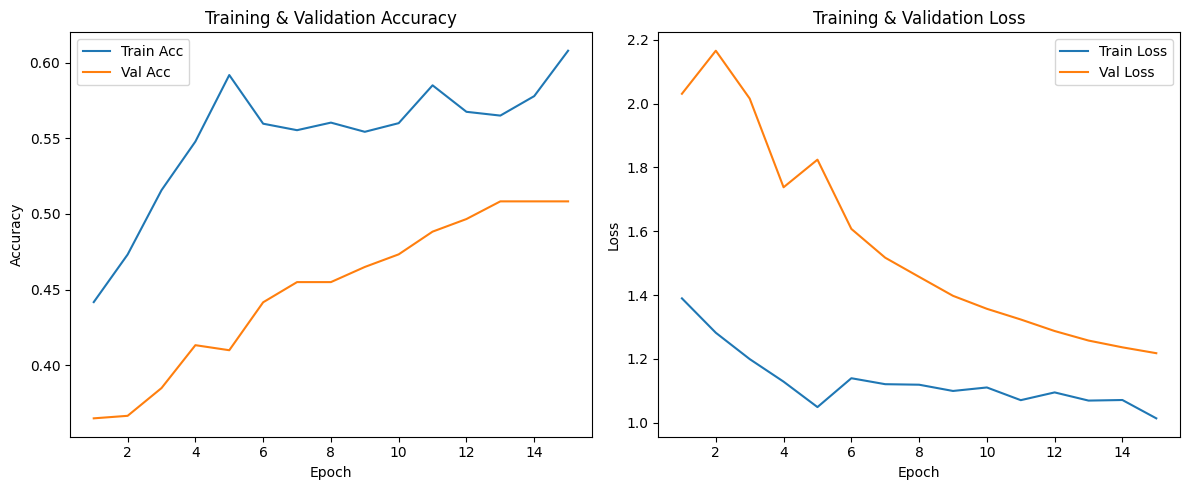

In [27]:
# Cell 9: Plot Combined Training & Validation Curves
import matplotlib.pyplot as plt

# Merge histories
acc      = history_head.history['accuracy']    + history_ft.history['accuracy']
val_acc  = history_head.history['val_accuracy']+ history_ft.history['val_accuracy']
loss     = history_head.history['loss']        + history_ft.history['loss']
val_loss = history_head.history['val_loss']    + history_ft.history['val_loss']
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,     label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,     label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
# Cell 10: Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Predictions & classification report
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print(classification_report(
    y_true, y_pred, target_names=CLASS_NAMES
))

19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4543 - loss: 1.3357
Test Loss: 1.2519, Test Accuracy: 0.4967
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
              precision    recall  f1-score   support

       Heart       0.47      0.44      0.45       120
      Oblong       0.69      0.39      0.50       120
        Oval       0.33      0.44      0.38       120
       Round       0.59      0.50      0.54       120
      Square       0.54      0.71      0.62       120

    accuracy                           0.50       600
   macro avg       0.53      0.50      0.50       600
weighted avg       0.53      0.50      0.50       600



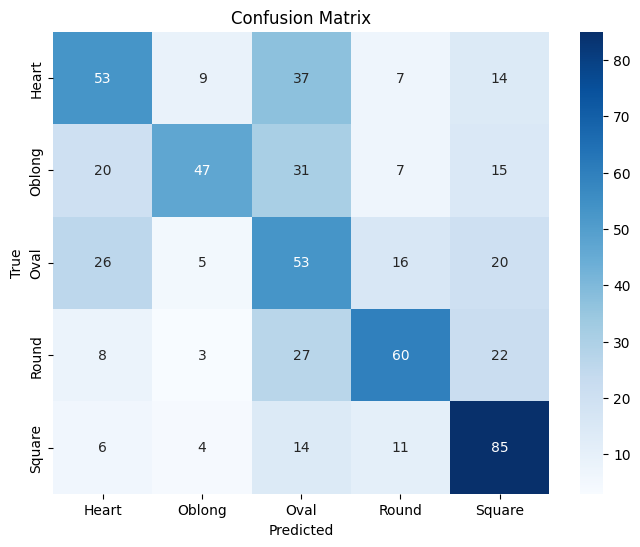

In [29]:
# Cell 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

In [30]:
# Cell 12: Fine-Tuning
# Unfreeze last ~20% of MobileNetV2
for layer in model.base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
fine_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5885 - loss: 1.0247
Epoch 1: val_accuracy did not improve from 0.50833
88/88 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.5887 - loss: 1.0246 - val_accuracy: 0.5083 - val_loss: 1.2817 - learning_rate: 1.0000e-04
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6550 - loss: 0.9155
Epoch 2: val_accuracy improved from 0.50833 to 0.51500, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.6550 - loss: 0.9154 - val_accuracy: 0.5150 - val_loss: 1.3618 - learning_rate: 1.0000e-04
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6936 - loss: 0.8052
Epoch 3: val_accuracy improved from 0.51500 to 0.54833, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.6936 - loss: 0.8052 - val_accuracy: 0.5483 - val_loss: 1.1677 - learning_rate: 1.0000e-04
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7327 - loss: 0.7036
Epoch 4: val_accuracy improved from 0.54833 to 0.56500, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7328 - loss: 0.7036 - val_accuracy: 0.5650 - val_loss: 1.1456 - learning_rate: 1.0000e-04
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7783 - loss: 0.6460
Epoch 5: val_accuracy improved from 0.56500 to 0.58500, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.7782 - loss: 0.6461 - val_accuracy: 0.5850 - val_loss: 1.1194 - learning_rate: 1.0000e-04
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8083 - loss: 0.5885
Epoch 6: val_accuracy did not improve from 0.58500
88/88 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8082 - loss: 0.5886 - val_accuracy: 0.5850 - val_loss: 1.1660 - learning_rate: 1.0000e-04
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8364 - loss: 0.4890
Epoch 7: val_accuracy improved from 0.58500 to 0.60833, saving model to /content/drive/MyDrive/face_shape_models/face_shape_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.8364 - loss: 0.4891 - val_accuracy: 0.6083 - val_loss: 1.0879 - learning_rate: 1.0000e-04
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8707 - loss: 0.4028
Epoch 8: val_accuracy did not improve from 0.60833
88/88 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.8705 - loss: 0.4030 - val_accuracy: 0.6050 - val_loss: 1.1042 - learning_rate: 1.0000e-04
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8893 - loss: 0.3619
Epoch 9: val_accuracy did not improve from 0.60833
88/88 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.8892 - loss: 0.3622 - val_accuracy: 0.5650 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8686 - loss: 0.3733
Epoch 10: val_accuracy did not improve from 0.60833

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
88/88 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.8686 - loss: 0.3734 - val_accura

In [31]:
# Cell 13: Save Final Model to Drive
final_model_path = os.path.join(OUTPUT_DIR, "face_shape_final.h5")
model.save(final_model_path)
print("Final model saved to", final_model_path)

Final model saved to /content/drive/MyDrive/face_shape_models/face_shape_final.h5
